In [1]:
import sys
import yaml
import pathlib
from datetime import datetime

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from albumentations import (
    HorizontalFlip, 
    VerticalFlip, 
    AdvancedBlur,
)
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure

sys.path.append(str(pathlib.Path('.').absolute().parent / 'src'))

## Dataset
from virtual_stain_flow.datasets.base_dataset import BaseImageDataset
from virtual_stain_flow.datasets.crop_cell_dataset import CropCellImageDataset
from virtual_stain_flow.datasets.cp_loaddata_dataset import CPLoadDataImageDataset
from virtual_stain_flow.datasets.aug_dataset import AugmentedBBoxImageDataset
from virtual_stain_flow.datasets.ram_cache_dataset import CompactRAMCache

## Losses/Metrics
from virtual_stain_flow.metrics.MetricsWrapper import MetricsWrapper
from virtual_stain_flow.metrics.PSNR import PSNR
from virtual_stain_flow.metrics.SSIM import SSIM
from virtual_stain_flow.losses.wgan_losses import (
    WassersteinDiscriminatorLoss,
    GradientPenaltyLoss,
    AdveserialGeneratorLoss
)

## Normalizations
from virtual_stain_flow.transforms import MaxScaleNormalize

## Models
from virtual_stain_flow.models.unet import UNet
from virtual_stain_flow.models.unext import ConvNeXtUNet
from virtual_stain_flow.models.discriminator import GlobalDiscriminator

## Trainers
from virtual_stain_flow.trainers.logging_trainers.LoggingTrainer import LoggingTrainer
from virtual_stain_flow.trainers.logging_trainers.LoggingGANTrainer import LoggingGANTrainer

## Logging
from virtual_stain_flow.vsf_logging.MlflowLogger import MlflowLogger
from virtual_stain_flow.vsf_logging.callbacks.PlotCallback import PlotPredictionCallback

/home/weishanli/anaconda3/envs/cp_gan_viscy_env/lib/python3.9/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Data Loading

In [2]:
CONFLUENCE = 1000

SAMPLE_N_VIEWS = 10

ANALYSIS_REPO_ROOT = pathlib.Path(
    '/home/weishanli/Waylab'
    ) / 'pediatric_cancer_atlas_analysis'
CONFIG_PATH = ANALYSIS_REPO_ROOT / 'config.yml'
config = yaml.safe_load(CONFIG_PATH.read_text())

LOADDATA_FILE_PATH = ANALYSIS_REPO_ROOT / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_train.csv'
assert LOADDATA_FILE_PATH.exists(), f"File not found: {LOADDATA_FILE_PATH}" 

PROFILING_DIR = pathlib.Path(config['paths']['pediatric_cancer_atlas_profiling_path'])
assert PROFILING_DIR.exists(), f"Directory not found: {PROFILING_DIR}"

SC_FEATURES_DIR = pathlib.Path(config['paths']['sc_features_path'])
assert SC_FEATURES_DIR.exists(), f"Directory not found: {SC_FEATURES_DIR}"

INPUT_CHANNEL_NAMES = config['data']['input_channel_keys']
TARGET_CHANNEL_NAMES = config['data']['target_channel_keys']

loaddata_df = pd.read_csv(LOADDATA_FILE_PATH)
print(f"Initial loaddata_df shape: {loaddata_df.shape}")
loaddata_df = loaddata_df.loc[loaddata_df['seeding_density'] == CONFLUENCE]
print(f"Filtered loaddata_df shape: {loaddata_df.shape}")
# downsample for testing
loaddata_df = loaddata_df.sample(n=SAMPLE_N_VIEWS, random_state=42)
print (f"Downsampled loaddata_df shape: {loaddata_df.shape}")

sc_feature_files = list(
        SC_FEATURES_DIR.glob('*_sc_normalized.parquet')
    )

sc_features = pd.DataFrame()
for plate in loaddata_df['Metadata_Plate'].unique():
    sc_features_parquet = SC_FEATURES_DIR / f'{plate}_sc_normalized.parquet'
    if not sc_features_parquet.exists():
        print(f'{sc_features_parquet} does not exist, skipping...')
        continue 
    else:
        sc_features = pd.concat([
            sc_features, 
            pd.read_parquet(
                sc_features_parquet,
                columns=['Metadata_Plate', 'Metadata_Well', 'Metadata_Site', 'Metadata_Cells_Location_Center_X', 'Metadata_Cells_Location_Center_Y']
            )
        ])

Initial loaddata_df shape: (402, 32)
Filtered loaddata_df shape: (79, 32)
Downsampled loaddata_df shape: (10, 32)


### 1.1 Create Raw Image Datasets

#### 1.1A Starting from scratch:
Compile your own `file_index` dataframe mapping channels (headers) to `.tiff` files,
as exemplified:    

In [3]:
filename_cols = loaddata_df.columns
filename_cols = [col for col in filename_cols if col.startswith('FileName_')]
filepath_cols = loaddata_df.columns
filepath_cols = [col for col in filepath_cols if col.startswith('PathName_')]

channel_strip_name_cols = [
    col.replace('FileName_', '')
    for col in filename_cols
]
channel_strip_path_cols = [
    col.replace('PathName_', '')
    for col in filepath_cols
]
channel_union = set(channel_strip_name_cols) & set(channel_strip_path_cols)
channel_union = list(channel_union)


file_index_df = pd.DataFrame(columns=channel_union, index=loaddata_df.index)
for channel in channel_union:
    file_index_df[channel] = loaddata_df.apply(
        lambda row: pathlib.Path(row[f'PathName_{channel}']) / str(row[f'FileName_{channel}']), axis=1)

file_index_df.reset_index(drop=True, inplace=False).head()

,OrigAGP,OrigMito,OrigDNA,OrigER,OrigRNA,OrigBrightfield
0,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...
1,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...
2,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...
3,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...
4,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...


Compile your own object level metadata as lists of dataframes

In [4]:
object_level_metadata_df_list = []

for _, row in loaddata_df.iterrows():
    metadata_plate = row['Metadata_Plate']
    metadata_well = row['Metadata_Well']
    metadata_site = row['Metadata_Site']
    
    filtered_sc_features = sc_features[
        (sc_features['Metadata_Plate'] == metadata_plate) &
        (sc_features['Metadata_Well'] == metadata_well) &
        (sc_features['Metadata_Site'] == metadata_site)
    ]    
    
    object_level_metadata_df_list.append(
        filtered_sc_features.loc[:, [
            # be sure to include columns indicating the location of objects
            'Metadata_Cells_Location_Center_X', 
            'Metadata_Cells_Location_Center_Y'
        ]].reset_index(drop=True, inplace=False)
    )

for i, obj_df in enumerate(object_level_metadata_df_list):
    print(f"Object-level metadata for view {i} shape: {obj_df.shape}")
    print(obj_df.head(2))
    if i >= 3:
        break

Object-level metadata for view 0 shape: (46, 2)
   Metadata_Cells_Location_Center_X  Metadata_Cells_Location_Center_Y
0                        567.443836                         42.643562
1                        155.710295                         75.313019
Object-level metadata for view 1 shape: (6, 2)
   Metadata_Cells_Location_Center_X  Metadata_Cells_Location_Center_Y
0                        220.597572                         97.753903
1                        558.697075                        140.468367
Object-level metadata for view 2 shape: (14, 2)
   Metadata_Cells_Location_Center_X  Metadata_Cells_Location_Center_Y
0                        115.221136                         93.403578
1                        838.324107                         76.970192
Object-level metadata for view 3 shape: (38, 2)
   Metadata_Cells_Location_Center_X  Metadata_Cells_Location_Center_Y
0                        146.725222                        259.691829
1                         88.814900    

Pass into the BaseImageDataset as `file_index` and `object_metadata`

In [5]:
ids = BaseImageDataset(
    file_index=file_index_df,
    pil_image_mode='I;16',
    metadata=None, # optional
    object_metadata=object_level_metadata_df_list, # needed for cropping, length must match file_index_df # rows
)

#### 1.1B if you have tiff files that are already cropped to small squares
Simply create a `BaseImageDataset` and skip to training

```
already_cropped_ids = BaseImageDataset(
    file_index=cropped_file_index_df,
    pil_image_mode='I;16',
)
```

#### 1.1C alternatively, if data index is generated for CellProfiler and segmentation results are available from CellProfiler, this dataset directly creates the right dataset with object level metadata

In [6]:
cp_ids = CPLoadDataImageDataset(
    loaddata=loaddata_df,
    sc_feature=sc_feature_files,
    pil_image_mode='I;16',
)

#### 1.2 Cropping cell containing patches from the dataset

In [7]:
crop_ds = CropCellImageDataset.from_dataset(
    cp_ids,
    patch_size=256,
    # specify which columns in object_metadata contain the x and y coordinates of the objects
    object_coord_x_field='Metadata_Cells_Location_Center_X',
    object_coord_y_field='Metadata_Cells_Location_Center_Y',
    fov=(1080, 1080)
)
# Perform Normalization
crop_ds.transform = MaxScaleNormalize(
    p=1, 
    normalization_factor=2**16 - 1,
)
crop_ds.input_channel_keys = ['OrigBrightfield']
crop_ds.target_channel_keys = ['OrigDNA']   

Generating object-centered crops...: 100%|██████████| 10/10 [00:00<00:00, 267.83it/s]


Visualize crops

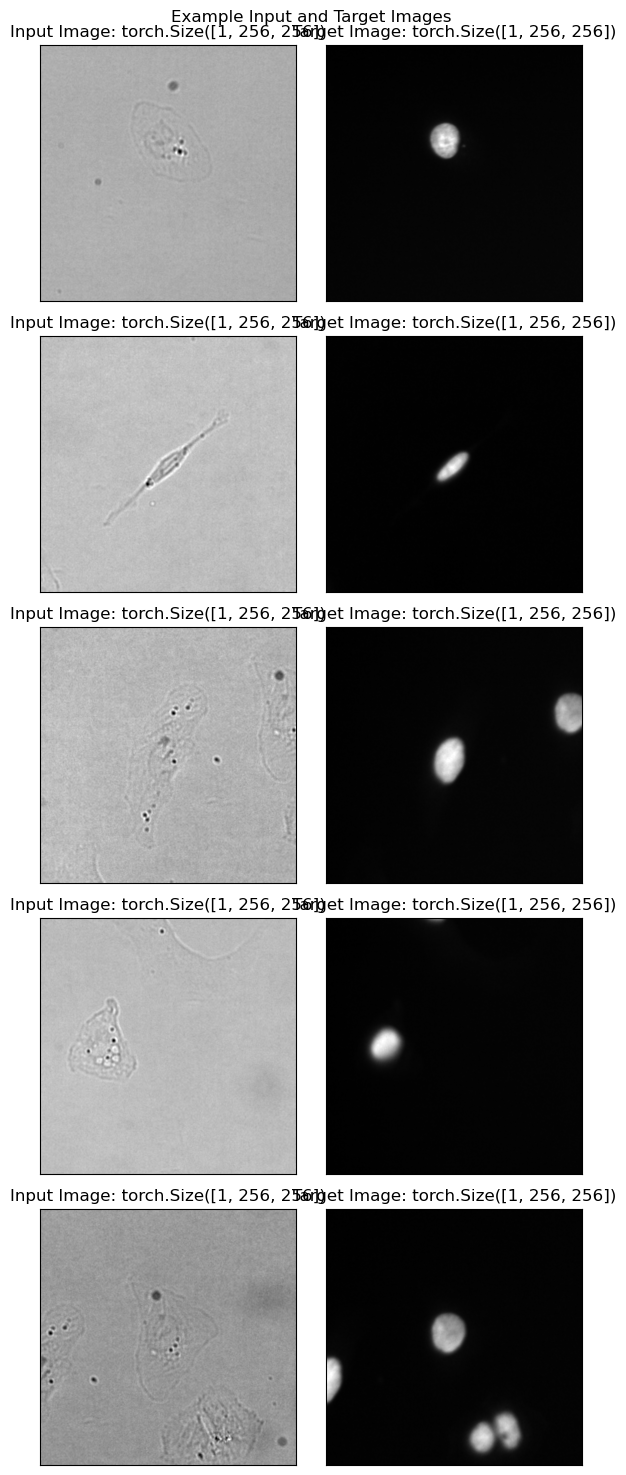

In [8]:
plot_idx = [1, 3, 5, 7, 9]
panel_width = 3

fig, axes = plt.subplots(
    len(plot_idx), 2, 
    figsize=(panel_width * 2, panel_width * len(plot_idx))) 

for i, idx in enumerate(plot_idx):
    
    input, target = crop_ds[idx]

    axes[i][0].imshow(input[0], cmap='gray')
    axes[i][0].set_title(f'Input Image: {input.shape}')
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][1].imshow(target[0], cmap='gray')
    axes[i][1].set_title(f'Target Image: {target.shape}')
    axes[i][1].set_xticks([])
    axes[i][1].set_yticks([])

plt.suptitle('Example Input and Target Images')
plt.tight_layout()

#### 1.3 [Optional] Raw Data Augmentation
If you want to introduce realistic image augmentations (rotation and translation)
around the crops without anytype of artificatial interpolation, use
`AugmentedBBoxImageDataset`.

In [9]:
print(f'Length of dataset before realistic augmentation: {len(crop_ds)}')

aug_ds = AugmentedBBoxImageDataset.from_dataset(
    crop_ds,
    augment_to_n=500, # specify how many total samples you want after augmentation
)

print(f'Length of dataset after realistic augmentation: {len(aug_ds)}')
aug_ds.input_channel_keys = ['OrigBrightfield']
aug_ds.target_channel_keys = ['OrigDNA']
aug_ds.transform = MaxScaleNormalize(
    p=1, 
    normalization_factor=2**16 - 1,
)

Length of dataset before realistic augmentation: 106
Length of dataset after realistic augmentation: 500


See we have different rotations of the second crop

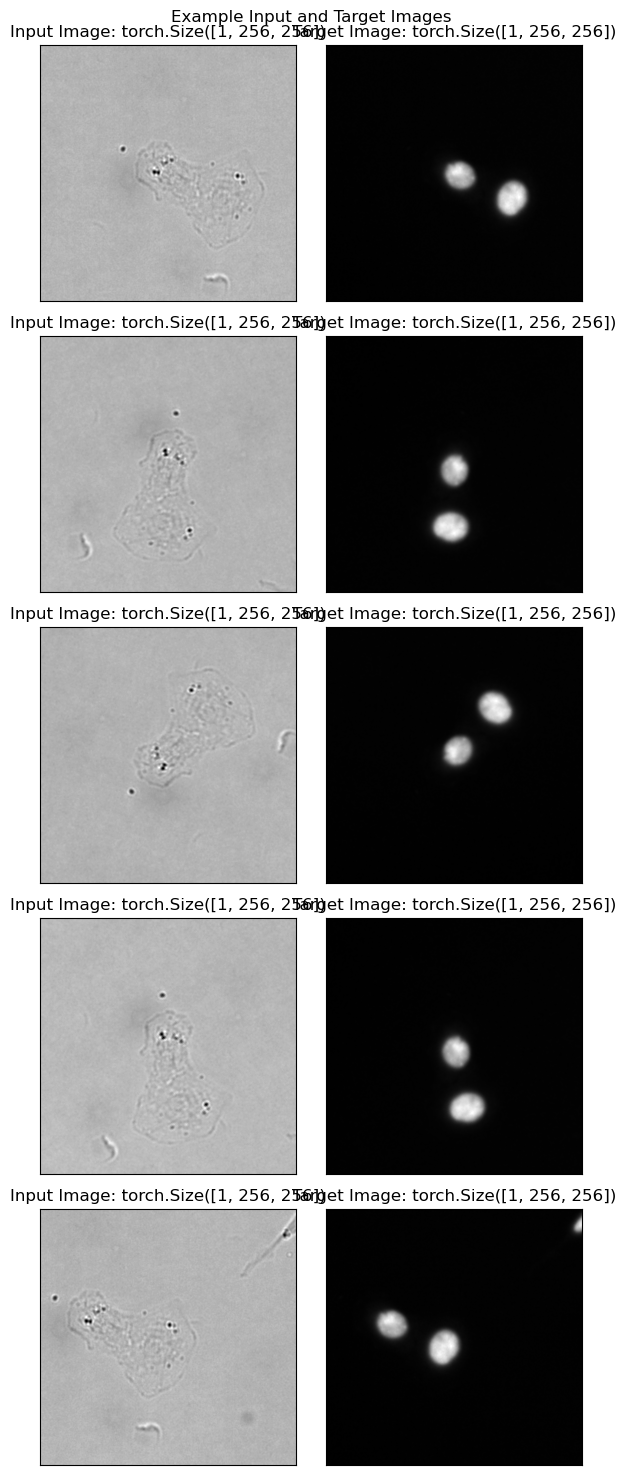

In [10]:
plot_idx = [2, 3, 5, 7, 9]
panel_width = 3

fig, axes = plt.subplots(
    len(plot_idx), 2, 
    figsize=(panel_width * 2, panel_width * len(plot_idx)))

for i, idx in enumerate(plot_idx):
    
    input, target = aug_ds[idx]

    axes[i][0].imshow(input[0], cmap='gray')
    axes[i][0].set_title(f'Input Image: {input.shape}')
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][1].imshow(target[0], cmap='gray')
    axes[i][1].set_title(f'Target Image: {target.shape}')
    axes[i][1].set_xticks([])
    axes[i][1].set_yticks([])

plt.suptitle('Example Input and Target Images')
plt.tight_layout()

#### 1.4 [Optional] Caching Dataset in RAM
The reduces the dataloader bottleneck especially when shuffling is enabled.

In [11]:
# note that the cache will apply the transform from the original dataset
# so the images cached here carry over the normalization transfrom from before
cached_dataset = CompactRAMCache(
    dataset=aug_ds,
    cache_size=None, # None cache all data
    
)

Caching items: 100%|██████████| 500/500 [00:01<00:00, 314.80it/s]


#### 1.5 [Optional] Final post-caching Augmentation
Apply any wanted `albumentation` transforms. 

In [12]:
# here we just have flips and blurs 
flip_transforms = [
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
]    
cached_dataset.transform = flip_transforms
cached_dataset.input_only_transform = AdvancedBlur(
    p=0.25,
    blur_limit=(5, 5),
    sigma_x_limit=(0.1, 0.2),
    sigma_y_limit=(0.1, 0.2),
    beta_limit=(0.5, 1.5),
    noise_limit=(0.9, 1.1)
)

Paired flipping and input blurring is randomly applied post-caching. 

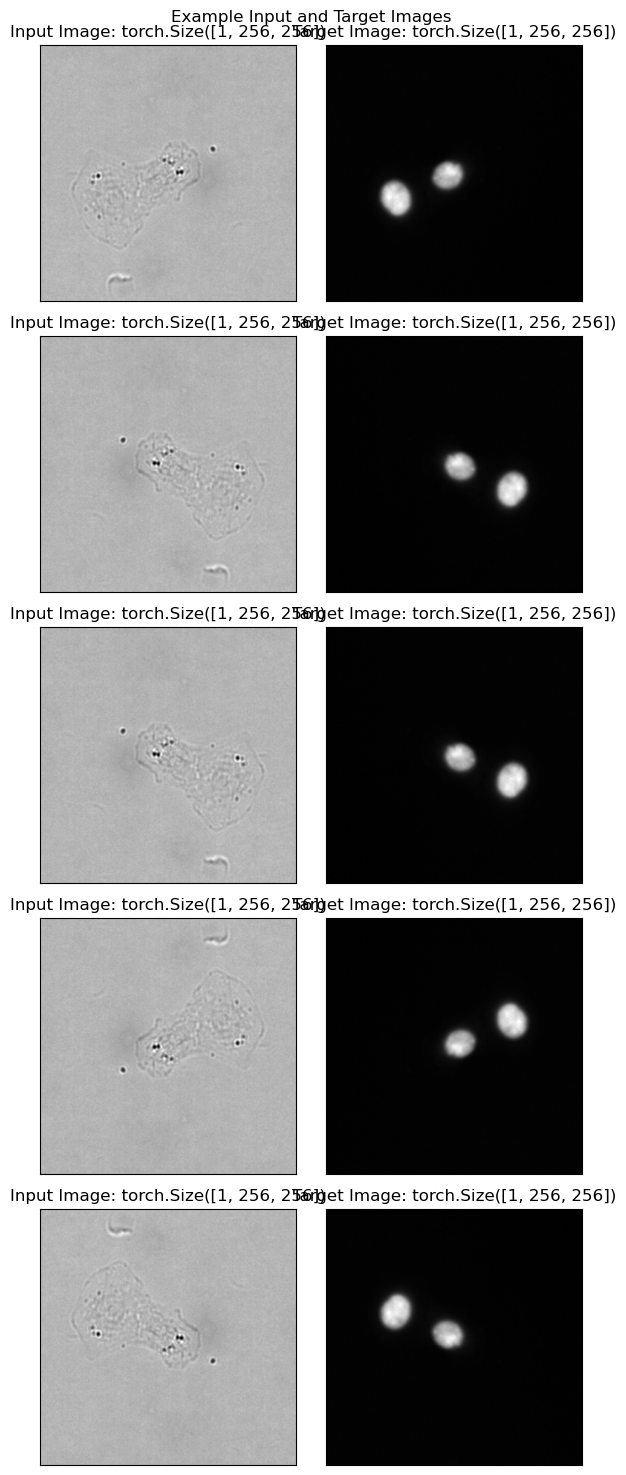

In [13]:
plot_idx = [2, 2, 2, 2, 2]
panel_width = 3

fig, axes = plt.subplots(
    len(plot_idx), 2, 
    figsize=(panel_width * 2, panel_width * len(plot_idx)))

for i, idx in enumerate(plot_idx):
    
    input, target = cached_dataset[idx]

    axes[i][0].imshow(input[0], cmap='gray')
    axes[i][0].set_title(f'Input Image: {input.shape}')
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][1].imshow(target[0], cmap='gray')
    axes[i][1].set_title(f'Target Image: {target.shape}')
    axes[i][1].set_xticks([])
    axes[i][1].set_yticks([])

plt.suptitle('Example Input and Target Images')
plt.tight_layout()

### 2. Training a wGAN

#### 2.1 Define mlflow tracking uri for centralized logging
For demonstration purposes we just log it here in the example folder.

In [14]:
EXAMPLE_DIR = pathlib.Path('.').absolute() / 'example_train'
EXAMPLE_DIR.mkdir(exist_ok=True)
TRAIN_PLOT_DIR = EXAMPLE_DIR / 'plot'
TRAIN_PLOT_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_LOG_DIR = EXAMPLE_DIR / 'mlflow'
TRAIN_LOG_DIR.mkdir(parents=True, exist_ok=True)

#### 2.2 Some configs

In [15]:
EPOCHS = 30

#### 2.3 [Optional] Compile tags to associate your train
Here we wanted to train a UNet generator based wGAN, so we add some descriptive detail 

In [16]:
tags = {
    'run_name': None,
    'architecture': 'UNet',
    'depth': 4,
    'base_channels': 64,
    'down_sample_mode': 'maxpool', # downsampling with maxpooling
    'up_sample_mode': 'convt', # upsampling with transposed conv
    'down_sample_block': 'conv2d>bn>relu',    
    'up_sample_block': 'conv2d>bn>relu',
    'up_sample_block_count': 2,
    'output_activation': 'sigmoid',
    'input_channels': ['OrigBrightfield'],
    'target_channels': ['OrigDNA'], # for demo we train model to predict DNA from Brightfield
    'dataset_length': len(crop_ds), # log the raw dataset length before augmentation
    'img_norm_method': 'maxscale',
    'generator_update_freq': 5,
    'discriminator_update_freq': 1,
    'optimizer': 'Adam',
    'optim_lr': 0.0002,
    'optim_betas': (0.5, 0.999),
    'discriminator_optimizer': 'Adam',
    'discriminator_optim_lr': 0.0002,
    'discriminator_optim_betas': (0.5, 0.999),
    'batch_size': 4,
    'early_termination_metric': 'L1Loss',
}

#### 2.4 Define loss functions 

In [17]:
loss = [
    # standard pixel-wise loss
    nn.L1Loss(),
    # wrap a MS-SSIM loss in wrapper for it to work
    # this helps model converge faster in earlier stage
    MetricsWrapper(
        _metric_name='MS-SSIM',
        module=MultiScaleStructuralSimilarityIndexMeasure(
            data_range=1.0,
            kernel_size=11,
            sigma=1.5
        ).to('cuda')
    ),
]

# corresponding weights for each loss
loss_weights = [
    1.0, # l1
    -1.0 # negative weight to MS-SSIM (higher=better)
]

# we can also log the loss functions
tags['loss'] = loss
tags['loss_weights'] = loss_weights

#### 2.5 Construct generator and discriminator models and optimizers

In [18]:
tags['run_name'] = 'wGAN_density=1000_hybrid_l1_msssim_loss_OrigDNA' # name however you like

model = UNet(
    # here we just use the tag parameters
    in_channels=len(tags['input_channels']),
    out_channels=len(tags['target_channels']),
    base_channels=tags['base_channels'],
    depth=tags['depth'],
    encoder_down_block=tags['down_sample_mode'],
    decoder_up_block=tags['up_sample_mode'] ,
    act_type='sigmoid',
    _num_units=tags['up_sample_block_count'],
)

model_optim = optim.Adam(
    model.parameters(),
    lr=tags['optim_lr'],
    betas=tags['optim_betas']
)

critic = GlobalDiscriminator(
    n_in_channels=len(tags['input_channels']) + len(tags['target_channels']),
    n_in_filters=tags['base_channels'],
    _leaky_relu_alpha=0.2,
    _batch_norm=True,
    _pool_before_fc=True
)

critic_optim = optim.Adam(
    critic.parameters(),
    lr=tags['discriminator_optim_lr'],
    betas=tags['discriminator_optim_betas']
)

#### 2.6 Construct Logger

In [19]:
now = datetime.now()
timestamp_string = now.strftime("%Y-%m-%d-%H:%M:%S")

run_name = tags['run_name']
PLOT_DIR = TRAIN_PLOT_DIR / ('plots_' + f'{run_name}_{timestamp_string}') 
PLOT_DIR.mkdir(exist_ok=True)

plot_callback = PlotPredictionCallback(
    name='plot_callback',
    save_path=PLOT_DIR,
    dataset=crop_ds,
    every_n_epochs=1,
    plot_metrics=[
        SSIM(_metric_name='ssim'), 
        PSNR(_metric_name='psnr')
        ],
    # kwargs passed to plotter
    show_plot=False,
)

logger = MlflowLogger(
    name='logger',
    tracking_uri = str(TRAIN_LOG_DIR / 'mlruns'),
    experiment_name='Default',
    run_name=f'train_{run_name}',
    experiment_type='train',
    model_architecture='UNet+wGAN',
    target_channel_name='OrigDNA',
    tags={
        key: str(value) for key, value in tags.items()
    },
    mlflow_start_run_args={
        'nested': False
    },
    save_model_at_train_end=True,
    save_model_every_n_epochs=1,
    save_best_model=True,
    callbacks=[plot_callback]    
)

#### 2.7 Construct Trainer and start training

In [20]:
metric_fns = {
    "ssim_loss": SSIM(_metric_name="ssim"),
    "psnr_loss": PSNR(_metric_name="psnr"),
}

trainer = LoggingGANTrainer(
    dataset=cached_dataset,

    generator=model,
    generator_optimizer=model_optim,
    generator_reconstruction_loss_fn=loss, # generator reconstruction loss defined above
    generator_reconstruction_loss_weights=loss_weights,
    generator_update_freq=tags['generator_update_freq'], # standard
    generator_adversarial_loss_fn=AdveserialGeneratorLoss(),

    discriminator=critic,
    discriminator_optimizer=critic_optim,
    discriminator_loss_fn=WassersteinDiscriminatorLoss(),
    gradient_penalty_loss_fn=GradientPenaltyLoss(),
    discriminator_update_freq=tags['discriminator_update_freq'],

    patience=EPOCHS,
    train_for_epochs=EPOCHS,
    batch_size=tags['batch_size'],
    metrics=metric_fns,
    device='cuda',
    early_termination_metric=tags['early_termination_metric']
)

In [21]:
trainer.train(logger=logger)

Training Progress: 100%|██████████| 30/30 [12:31<00:00, 25.05s/epoch]


#### Check logged items

In [22]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri(str(TRAIN_LOG_DIR / 'mlruns'))
client = MlflowClient()
experiments = client.search_experiments()
runs_df = mlflow.search_runs(experiment_ids=[experiments[0].experiment_id])
runs_df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_MetricsWrapper,metrics.train_AdversarialGeneratorLoss,metrics.train_ssim_loss,metrics.train_GradientPenaltyLoss,...,tags.discriminator_optimizer,tags.mlflow.runName,tags.target_channel_name,tags.optim_betas,tags.base_channels,tags.img_norm_method,tags.output_activation,tags.run_name,tags.mlflow.source.name,tags.down_sample_mode
0,ff10610fe6e24c66b3518b4f5b3b91d8,0,RUNNING,/home/weishanli/Waylab/virtual_stain_flow/exam...,2025-08-28 22:05:41.755000+00:00,None,0.883888,-0.466811,0.688969,0.096086,...,Adam,train_wGAN_density=1000_hybrid_l1_msssim_loss_...,OrigDNA,"(0.5, 0.999)",64,maxscale,sigmoid,wGAN_density=1000_hybrid_l1_msssim_loss_OrigDNA,/home/weishanli/anaconda3/envs/cp_gan_viscy_en...,maxpool


#### Examine logged artifacts
See that the prediction plots, epoch weights and best weights are all present

In [23]:
run_id = runs_df['run_id'].iloc[0]
def list_all_artifacts(client, run_id, path=""):
    all_paths = []
    items = client.list_artifacts(run_id, path)
    for item in items:
        if item.is_dir:
            all_paths.extend(list_all_artifacts(client, run_id, item.path))
        else:
            all_paths.append(item.path)
    return all_paths

all_artifact_paths = list_all_artifacts(client, run_id)
for path in all_artifact_paths:
    print(path)

configs/model_config.json
plots/epoch/plot_predictions/epoch_1.png
plots/epoch/plot_predictions/epoch_10.png
plots/epoch/plot_predictions/epoch_11.png
plots/epoch/plot_predictions/epoch_12.png
plots/epoch/plot_predictions/epoch_13.png
plots/epoch/plot_predictions/epoch_14.png
plots/epoch/plot_predictions/epoch_15.png
plots/epoch/plot_predictions/epoch_16.png
plots/epoch/plot_predictions/epoch_17.png
plots/epoch/plot_predictions/epoch_18.png
plots/epoch/plot_predictions/epoch_19.png
plots/epoch/plot_predictions/epoch_2.png
plots/epoch/plot_predictions/epoch_20.png
plots/epoch/plot_predictions/epoch_21.png
plots/epoch/plot_predictions/epoch_22.png
plots/epoch/plot_predictions/epoch_23.png
plots/epoch/plot_predictions/epoch_24.png
plots/epoch/plot_predictions/epoch_25.png
plots/epoch/plot_predictions/epoch_26.png
plots/epoch/plot_predictions/epoch_27.png
plots/epoch/plot_predictions/epoch_28.png
plots/epoch/plot_predictions/epoch_29.png
plots/epoch/plot_predictions/epoch_3.png
plots/epoch

### 3. Training simpler, single generator model


end previous run

In [24]:
mlflow.end_run()

#### 3.1 Tags

In [25]:
tags = {
    'run_name': 'unet_density=1000_hybrid_l1_msssim_loss_OrigDNA',
    'architecture': 'UNet',
    'depth': 4,
    'base_channels': 64,
    'down_sample_mode': 'conv', 
    'up_sample_mode': 'convt',
    'down_sample_block': 'conv2d>bn>relu',    
    'up_sample_block': 'conv2d>bn>relu',
    'up_sample_block_count': 2,
    'output_activation': 'sigmoid',
    'input_channels': ['OrigBrightfield'],
    'target_channels': ['OrigDNA'], 
    'dataset_length': len(crop_ds), 
    'img_norm_method': 'maxscale',
    'generator_update_freq': 5,
    'discriminator_update_freq': 1,
    'optimizer': 'Adam',
    'optim_lr': 0.0002,
    'optim_betas': (0.5, 0.999),
    'batch_size': 4,
    'early_termination_metric': 'L1Loss',
}

#### 3.2 Same hybrid loss 

In [26]:
loss = [
    # standard pixel-wise loss
    nn.L1Loss(),
    # wrap a MS-SSIM loss in wrapper for it to work
    # this helps model converge faster in earlier stage
    MetricsWrapper(
        _metric_name='MS-SSIM',
        module=MultiScaleStructuralSimilarityIndexMeasure(
            data_range=1.0,
            kernel_size=11,
            sigma=1.5
        ).to('cuda')
    ),
]

# corresponding weights for each loss
loss_weights = [
    1.0, # l1
    -1.0 # negative weight to MS-SSIM (higher=better)
]

# we can also log the loss functions
tags['loss'] = loss
tags['loss_weights'] = loss_weights

#### 3.3 Construct single UNet

In [27]:
model = UNet(
    # here we just use the tag parameters
    in_channels=len(tags['input_channels']),
    out_channels=len(tags['target_channels']),
    base_channels=tags['base_channels'],
    depth=tags['depth'],
    encoder_down_block=tags['down_sample_mode'],
    decoder_up_block=tags['up_sample_mode'] ,
    act_type='sigmoid',
    _num_units=tags['up_sample_block_count'],
)

model_optim = optim.Adam(
    model.parameters(),
    lr=tags['optim_lr'],
    betas=tags['optim_betas']
)

#### 3.4 Same logging infranstructure 

In [28]:
now = datetime.now()
timestamp_string = now.strftime("%Y-%m-%d-%H:%M:%S")

run_name = tags['run_name']
PLOT_DIR = TRAIN_PLOT_DIR / ('plots_' + f'{run_name}_{timestamp_string}') 
PLOT_DIR.mkdir(exist_ok=True)

plot_callback = PlotPredictionCallback(
    name='plot_callback',
    save_path=PLOT_DIR,
    dataset=crop_ds,
    every_n_epochs=1,
    plot_metrics=[
        SSIM(_metric_name='ssim'), 
        PSNR(_metric_name='psnr')
        ],
    # kwargs passed to plotter
    show_plot=False,
)

logger = MlflowLogger(
    name='logger',
    tracking_uri = str(TRAIN_LOG_DIR / 'mlruns'),
    experiment_name='Default',
    run_name=f'train_{run_name}',
    experiment_type='train',
    model_architecture='UNet',
    target_channel_name='OrigDNA',
    tags={
        key: str(value) for key, value in tags.items()
    },
    mlflow_start_run_args={
        'nested': False
    },
    save_model_at_train_end=True,
    save_model_every_n_epochs=1,
    save_best_model=True,
    callbacks=[plot_callback]    
)

#### 3.5 Use single generator Trainer 

In [29]:
metric_fns = {
    "ssim_loss": SSIM(_metric_name="ssim"),
    "psnr_loss": PSNR(_metric_name="psnr"),
}

_ = model.to('cuda')

trainer = LoggingTrainer(
    dataset=cached_dataset,

    model=model,
    optimizer=model_optim,
    backprop_loss=loss,
    backprop_loss_weights=loss_weights,

    patience=EPOCHS,
    train_for_epochs=EPOCHS,
    batch_size=tags['batch_size'],
    metrics=metric_fns,
    device='cuda',
    early_termination_metric=tags['early_termination_metric']
)

In [30]:
trainer.train(logger=logger)

Training Progress:  23%|██▎       | 7/30 [01:50<06:04, 15.85s/epoch]

Active run (121e6c13e4564f999188c07ab3d5bca9) does not match logger's run (ff10610fe6e24c66b3518b4f5b3b91d8). Not ending.


Training Progress: 100%|██████████| 30/30 [07:59<00:00, 15.99s/epoch]


In [31]:
mlflow.set_tracking_uri(str(TRAIN_LOG_DIR / 'mlruns'))
client = MlflowClient()
experiments = client.search_experiments()
runs_df = mlflow.search_runs(experiment_ids=[experiments[0].experiment_id])
runs_df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_MetricsWrapper,metrics.train_ssim_loss,metrics.train_L1Loss,metrics.val_ssim_loss,...,tags.output_activation,tags.up_sample_block_count,tags.run_name,tags.mlflow.source.name,tags.optim_lr,tags.down_sample_mode,tags.down_sample_block,tags.discriminator_optim_betas,tags.discriminator_optim_lr,tags.discriminator_optimizer
0,121e6c13e4564f999188c07ab3d5bca9,0,RUNNING,/home/weishanli/Waylab/virtual_stain_flow/exam...,2025-08-28 22:18:13.607000+00:00,NaT,0.971904,0.923346,0.005229,0.870803,...,sigmoid,2,unet_density=1000_hybrid_l1_msssim_loss_OrigDNA,/home/weishanli/anaconda3/envs/cp_gan_viscy_en...,0.0002,conv,conv2d>bn>relu,None,None,None
1,ff10610fe6e24c66b3518b4f5b3b91d8,0,FINISHED,/home/weishanli/Waylab/virtual_stain_flow/exam...,2025-08-28 22:05:41.755000+00:00,2025-08-28 22:18:13.456000+00:00,0.883888,0.688969,0.012038,0.680074,...,sigmoid,2,wGAN_density=1000_hybrid_l1_msssim_loss_OrigDNA,/home/weishanli/anaconda3/envs/cp_gan_viscy_en...,0.0002,maxpool,conv2d>bn>relu,"(0.5, 0.999)",0.0002,Adam


In [32]:
!rm -rf example_train/